Are the contaminants being injected into the water column within the Salish Sea Atlantis Model within a timescale of 10 days as we might expect? 

How about uptake by the phytoplankton?

### Highres Tests
- v6699_16 - updated code version (see SSAM-output-biopools.ipynb)
- v6699_17 - updated code version + small number dummy contaminant file to zero out contaminants, but flag_dissolved_pollutants = 0
- highres3 - reduced uptake rates of PAH for diatoms and picos to around 8.0e-03 mg/m^3 per day
- v6699_17A - flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 1
- v6699_17B - flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 0
- v6699_18 - bm->dayt in decay calculation, flag_dissolved_pollutants = 1, PAH_dissolv_coefft = 0
- v6699_18B - removed (/time_step) so that sp_amount_decayed = cGroupLevel - newValue
- v6699_18C - test to see if 18B still works if time_step = dt rather than dayt.
- v6699_18D - put time_step back to dt, but in atContaminants.c line 1094, instead of using cLevel in Calculate_Species_Contaminant_Decay, defined cGroupLevel = tracerArray[FunctGroupArray[sp].contaminantTracers[cohort][cIndex]]; and then defined the tracerArray as getTracerArray(boxLayerInfo, habitat) except for EPIFAUNA (getTracerArray(boxLayerInfo, WC))
- v6699_18E - added a decay_constant defined by the half-life, and defined the new_value = cGroupLevel * decay_constant * time_step;
- v6699_18F - tracerArray = getTracerArray(boxLayerInfo, habitat); left off bit about epifauna as it crashed the longer runs.
- v6699_18G - return half_life equation to original while leaving other changes
- v6699_19A - remove ability of contaminants pass from detritus to bio through predation + turned on flag_dissolved_pollutants
- v6699_20 - remove ability of contaminants to pass back to the water column

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

### Package and file imports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from PIL import Image
import glob
from IPython.display import Image as img
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
control_name = 'v6699_17A_highres_90d'
#control_name = 'v6699_16_highres'
test_name = 'v6699_18F_highres_90d'
test2_name = 'v6699_18G_highres_90d'
test3_name = 'v6699_20_highres_90d'
labels = [control_name,test_name,test2_name, test3_name]
testlabels = [test_name, test2_name, test3_name]

In [3]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [4]:
time_c = np.ma.filled(control.variables['t'], np.nan)

In [5]:
test_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_" + test_name + "/outputSalishSea.nc"
test2_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_" + test2_name + "/outputSalishSea.nc"
test = xr.open_dataset(str(test_path), decode_cf=True)
test2= xr.open_dataset(str(test2_path), decode_cf=True)

In [6]:
test3_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_" + test3_name + "/outputSalishSea.nc"
test3= xr.open_dataset(str(test3_path), decode_cf=True)

In [7]:
time = np.ma.filled(test3.variables['t'], np.nan)

In [8]:
scenarios = [control, test, test2, test3]
scens = [test, test2, test3]
scen3 = [test3]
scenlabels = [test_name, test2_name, test3_name]
cont = [control]

### Functions

In [9]:
def plot_pah(scenario, times, label):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH')
    ax.set_title(label)

In [10]:
def plot_individual_pah(scenario, times, label, pah):
    fig, ax = plt.subplots(figsize = (14,3))
    contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(pah)
    ax.set_ylabel('mg PAH')
    ax.set_title(label)

In [11]:
def tissue_mass(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
            oil_mass_tbl = oil_tbl * volume_tbl
            oil_mass_tb = oil_mass_tbl.sum(axis=2) 
            oil_mass_t = oil_mass_tb.sum(axis=1) 
            ax.plot(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5) #semilogy
        
        #plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);
    #print(sp_volume_tbl[1,60,:])
    #print(sp_volume_tbl[1,60,:]+(sp_volume_tbl[3,60,:]==0))

In [12]:
def individual_tissue_mass(species, pah, scens, names=labels, time=time):

    fig, ax = plt.subplots(figsize = (14,3))
    for scenario in scens:
        oil_tbl = np.ma.filled(scenario.variables[species + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
        oil_mass_tbl = oil_tbl * volume_tbl
        oil_mass_tb = oil_mass_tbl.sum(axis=2) 
        oil_mass_t = oil_mass_tb.sum(axis=1) 
        ax.plot(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5) #semilogy
    
    plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
    ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [13]:
def individual_tissue_mass_log(species, pah, scens, names=labels, time=time):

    fig, ax = plt.subplots(figsize = (14,3))
    for scenario in scens:
        oil_tbl = np.ma.filled(scenario.variables[species + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
        oil_mass_tbl = oil_tbl * volume_tbl
        oil_mass_tb = oil_mass_tbl.sum(axis=2) 
        oil_mass_t = oil_mass_tb.sum(axis=1) 
        ax.semilogy(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5)
    
    plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
    ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [14]:
def tissue_mass_log(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan)
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan)
            oil_per_N_tbl = oil_tbl * (1/(volume_tbl+(volume_tbl==0)))
            oil_per_N_tb = oil_per_N_tbl.sum(axis=2) 
            oil_per_N_t = oil_per_N_tb.sum(axis=1) 
            ax.semilogy(time, oil_per_N_t[0:time.size],linewidth = 2, alpha=0.5)
        
        plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [27]:
def plot_biomass(group, scens, names=labels):
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2)
            pelagic_oiled = pelagic_oiled.sum(axis=1)
            ax.plot(time, pelagic_oiled[0:time.size], linewidth = 2)
        
        plt.ylabel('mg N m$^{-3}$', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [28]:
def map_tissue_mass(group, pah, scenarios, v_max=None, v_min=None, _cmap=cm.Purples):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(group), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for species in group:
        for scenario in scenarios:
            dVar_s = scenario.variables[group[species] + '_' + pah][:,:,0:6]
            volume = scenario.variables['volume'][:,:,0:6]
            #dVar_s = dVar_s.sum(axis=2)
            dVar_mass = dVar_s * volume
            vpah_tb = dVar_mass.sum(axis=2)
            vpah_b = vpah_tb.sum(axis=0)

            # Add scenario data to Atlantis spatial data
            map_df['pah'] = vpah_b
            map_df.loc[land_boxes, 'pah'] = 0

            ax = fig.add_subplot(gs[0, position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
                legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
                )
            tit = str(species + '_' + pah)
            ax.set_title(tit)
            map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');
        position=position+1

In [29]:
def map_aggregate_time(variable_name, scens, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name]
        dVar_s = dVar_s.mean(axis=2)
        pah = dVar_s.mean(axis=0)

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(names[scenario.index], fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1

In [30]:
def map_time_mass(variable_name, scens, time, names=labels, v_max=None, v_min=None):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        var_bl = scenario.variables[variable_name][time,:,0:6]
        vol_bl = scenario.variables['volume'][time,:,0:6]
        var_mass_bl = var_bl * vol_bl
        var_mass_b = var_mass_bl.mean(axis=1)

        # Add scenario data to Atlantis spatial data
        map_df[variable_name] = var_mass_b
        map_df.loc[land_boxes, variable_name] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = variable_name, cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(variable_name, fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
    fig.suptitle(names)

In [31]:
def map_time_depth(variable_name, scens, time, depth, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    depth_range = ['700 m','400 m', '250 m', '100 m', '50 m', 'surface 25 m', 'sediment']
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name][time,:,depth]
        #dVar_s = dVar_s.mean(axis=1)
        #pah_s = dVar_s.mean(axis=1)
        pah_s = dVar_s

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah_s
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title((variable_name + ' - ' + depth_range[depth] + '_' + str(time)), fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
        map_df['pah'] = 0

### Water Column

For successful contaminant injection, putting the final file to have a very small number instead of 0 works the best.

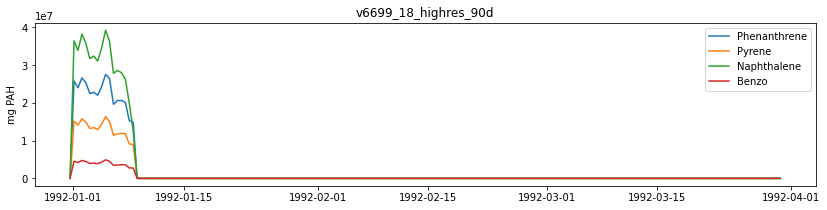

In [71]:
plot_pah(test2, time, label=test2_name)

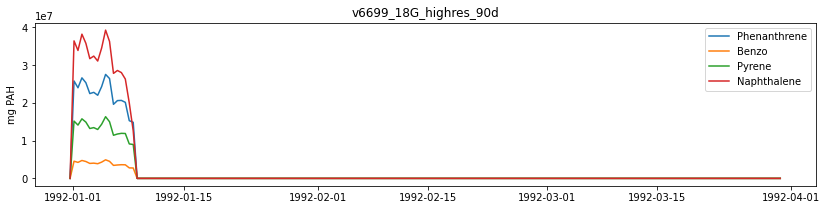

In [15]:
plot_pah(test2, time, label=test2_name)

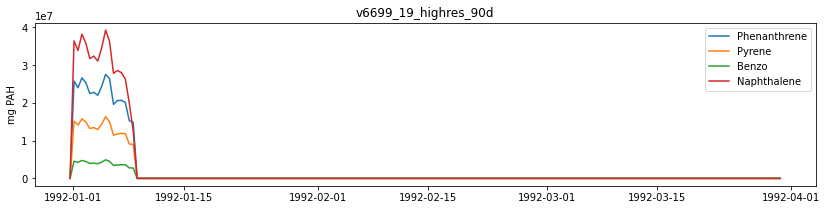

In [15]:
plot_pah(test3, time, label=test3_name)

Text(0.5, 1.0, 'v6699_18C_highres_90d')

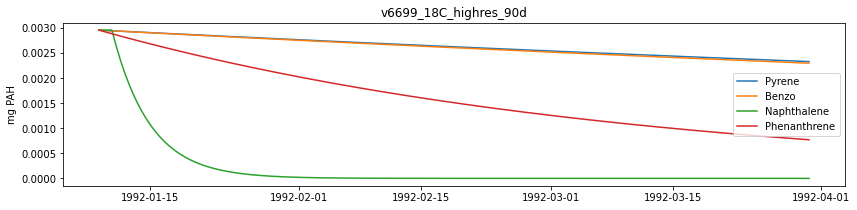

In [33]:
fig, ax = plt.subplots(figsize = (14,3))
for pah in groups.pahs:
    contam_tbl = np.ma.filled(test3.variables[pah], np.nan)
    volume_tbl = np.ma.filled(test3.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(time[17:time.size], contam_mass_t[17:time.size])
ax.legend(groups.pahs)
ax.set_ylabel('mg PAH')
ax.set_title(test3_name)

Showing that the concentration at the end of the run is still not 0, but just very low compared to the input data. 

### Phytoplankton

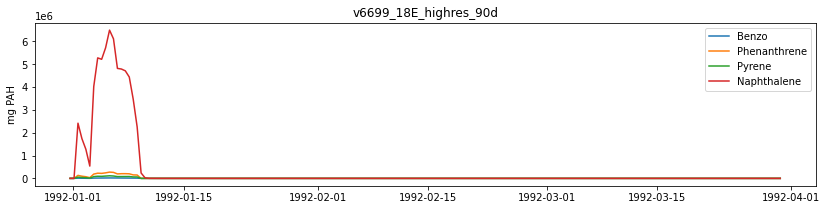

In [28]:
scenario = test3
fig, ax = plt.subplots(figsize = (14,3))
for pah in groups.pahs:
    name = 'PicoPhytopl_' + pah
    contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(time, contam_mass_t[0:time.size])
ax.legend(groups.pahs)
ax.set_ylabel('mg PAH')
ax.set_title(test3_name);

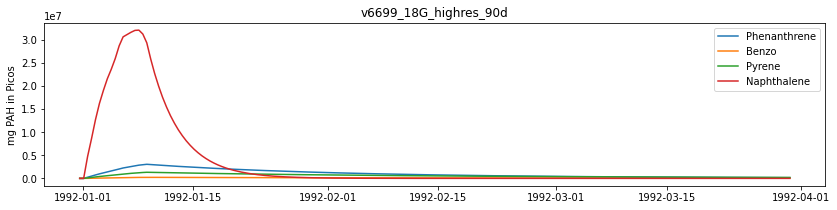

In [17]:
scenario = test2
fig, ax = plt.subplots(figsize = (14,3))
for pah in groups.pahs:
    name = 'PicoPhytopl_' + pah
    contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(time, contam_mass_t[0:time.size])
ax.legend(groups.pahs)
ax.set_ylabel('mg PAH in Picos')
ax.set_title(test2_name);

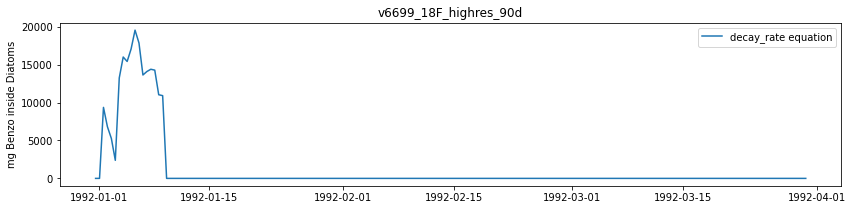

In [23]:
scenario = test
fig, ax = plt.subplots(figsize = (14,3))
pah = 'Benzo'
name = 'Diatom_' + pah
contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
volume_tbl = np.ma.filled(scenario.volume, np.nan)
contam_mass_tbl = contam_tbl * volume_tbl
contam_mass_tb = contam_mass_tbl.sum(axis=2)
contam_mass_t = contam_mass_tb.sum(axis=1)

ax.plot(time, contam_mass_t[0:time.size])
ax.legend(['decay_rate equation'])
ax.set_ylabel('mg Benzo inside Diatoms')
ax.set_title(test_name);

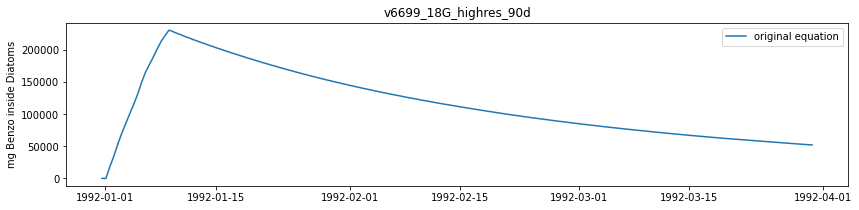

In [21]:
scenario = test2
fig, ax = plt.subplots(figsize = (14,3))
pah = 'Benzo'
name = 'Diatom_' + pah
contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
volume_tbl = np.ma.filled(scenario.volume, np.nan)
contam_mass_tbl = contam_tbl * volume_tbl
contam_mass_tb = contam_mass_tbl.sum(axis=2)
contam_mass_t = contam_mass_tb.sum(axis=1)

ax.plot(time, contam_mass_t[0:time.size])
ax.legend(['original equation'])
ax.set_ylabel('mg Benzo inside Diatoms')
ax.set_title(test2_name);

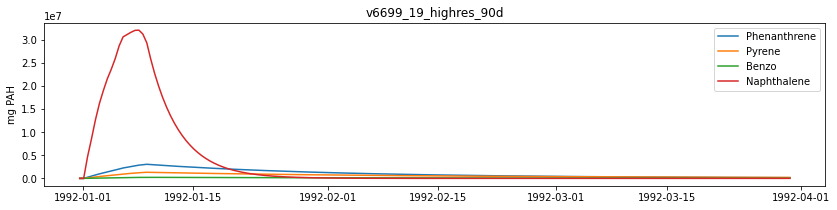

In [16]:
scenario = test3
fig, ax = plt.subplots(figsize = (14,3))
for pah in groups.pahs:
    name = 'PicoPhytopl_' + pah
    contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(time, contam_mass_t[0:time.size])
ax.legend(groups.pahs)
ax.set_ylabel('mg PAH')
ax.set_title(test3_name);

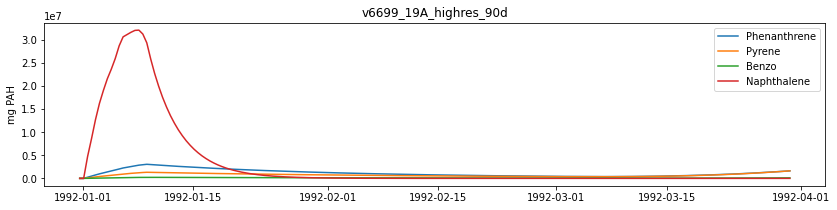

In [26]:
scenario = test3
fig, ax = plt.subplots(figsize = (14,3))
for pah in groups.pahs:
    name = 'PicoPhytopl_' + pah
    contam_tbl = np.ma.filled(scenario.variables[name], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(time, contam_mass_t[0:time.size])
ax.legend(groups.pahs)
ax.set_ylabel('mg PAH')
ax.set_title(test3_name);

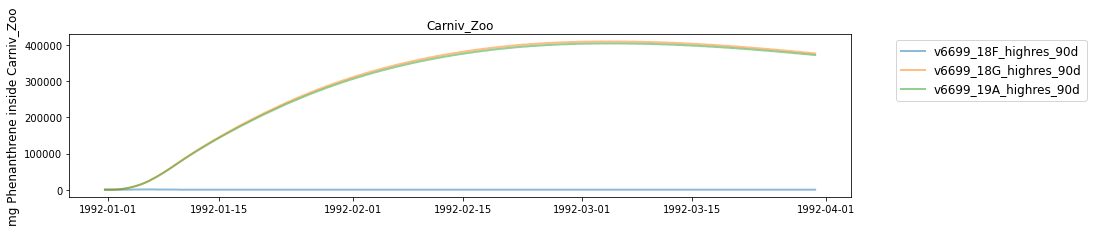

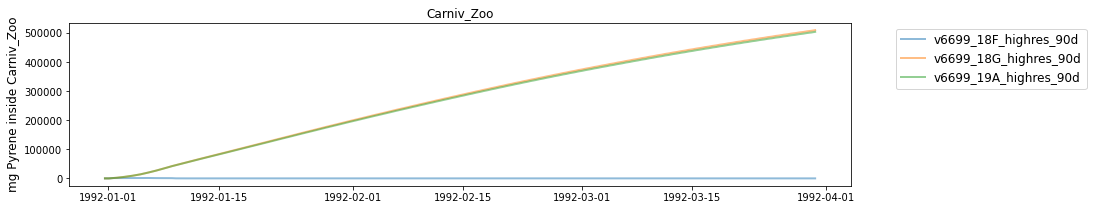

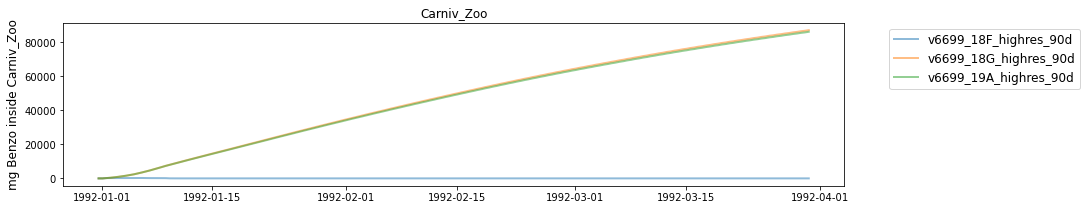

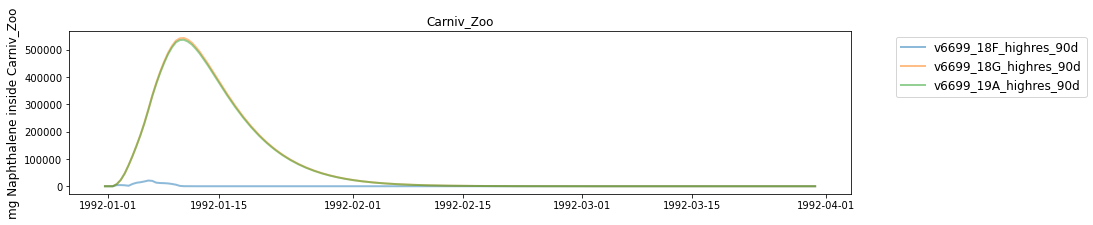

In [30]:
for pah in groups.pahs:
    individual_tissue_mass('Carniv_Zoo', pah, scens, testlabels)

In [36]:
diatom_naph_tbl = np.ma.filled(test3.variables['Diatom_Naphthalene'][:,:,0:6], np.nan)
diatom_naph_tb = diatom_naph_tbl.sum(axis=2)
diatom_naph_t =  diatom_naph_tb.sum(axis=1)
diatom_naph = diatom_naph_t.sum()
diatom_naph

0.0

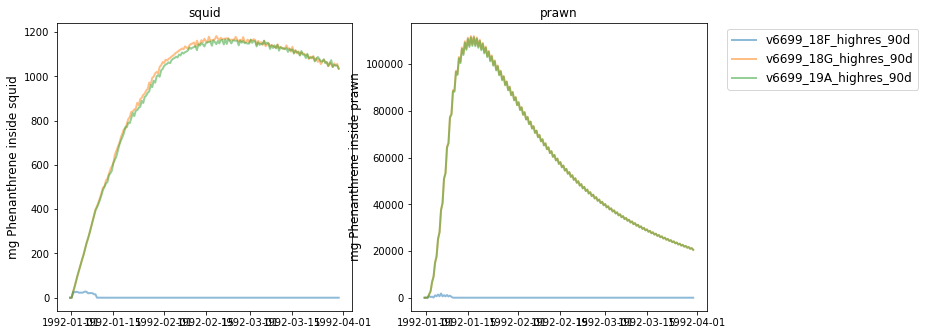

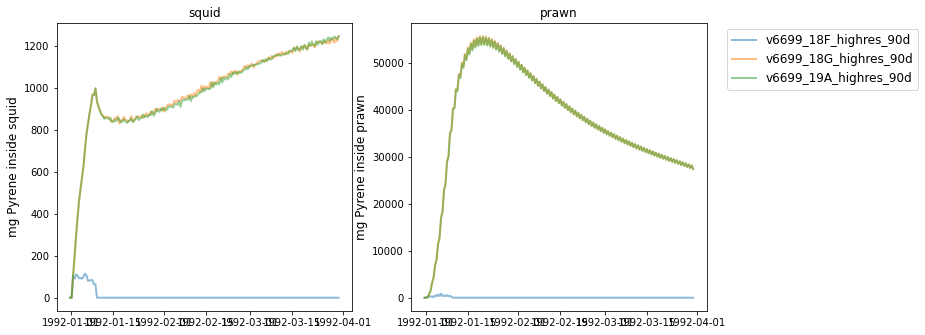

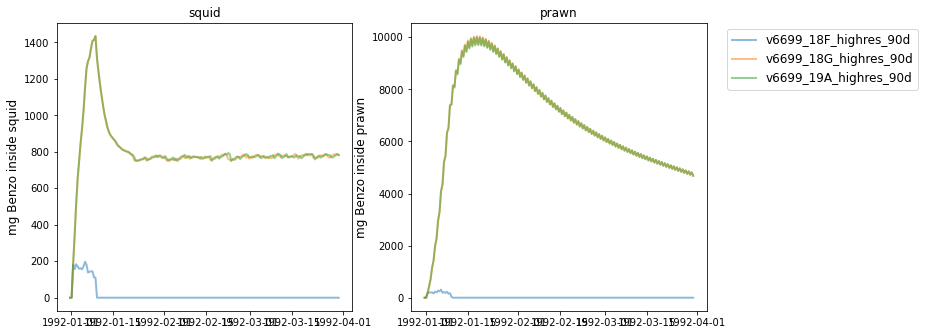

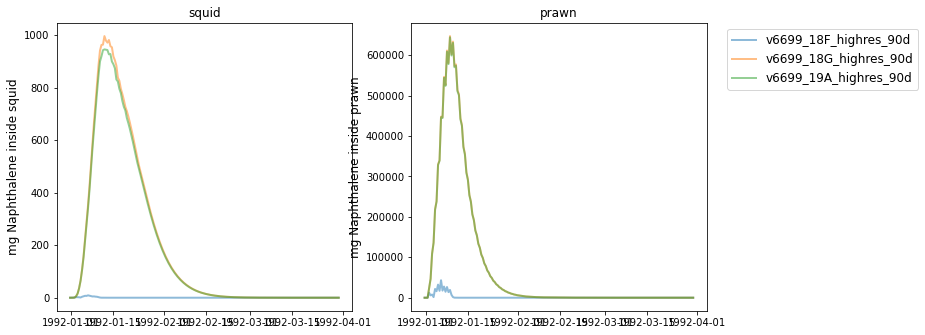

In [28]:
for pah in groups.pahs:
    tissue_mass(groups.pelagic_invertebrates, pah, scens, testlabels)

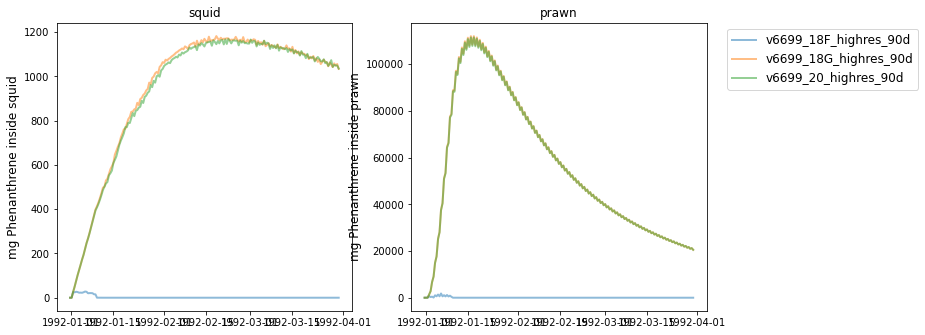

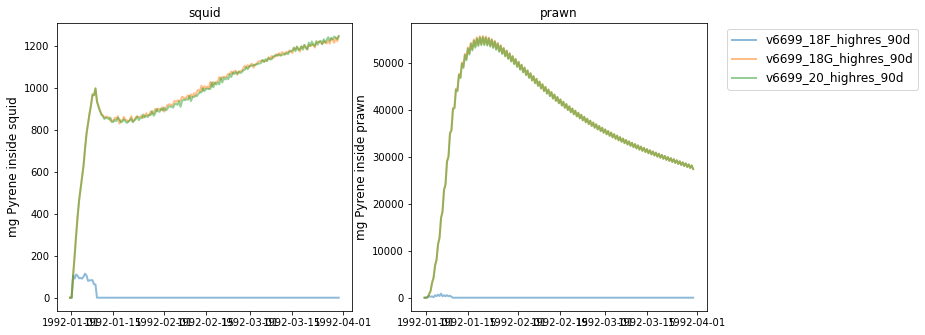

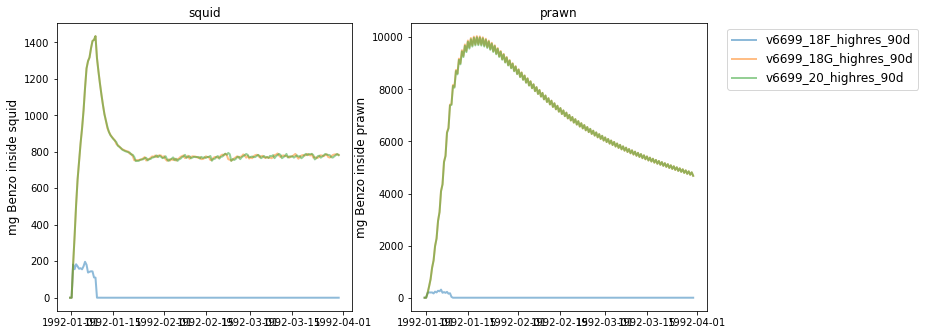

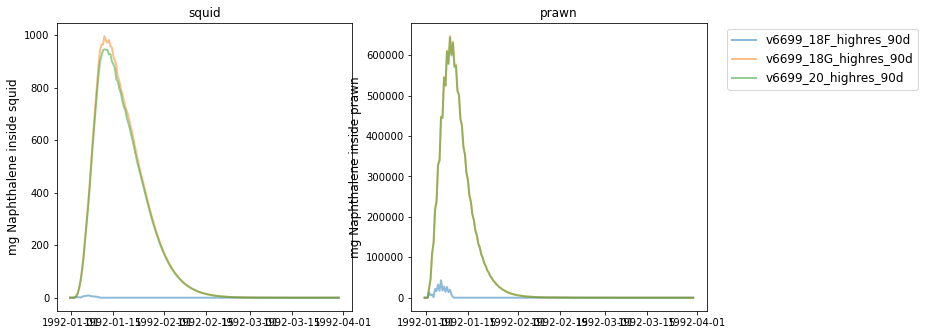

In [37]:
for pah in groups.pahs:
    tissue_mass(groups.pelagic_invertebrates, pah, scens, testlabels)

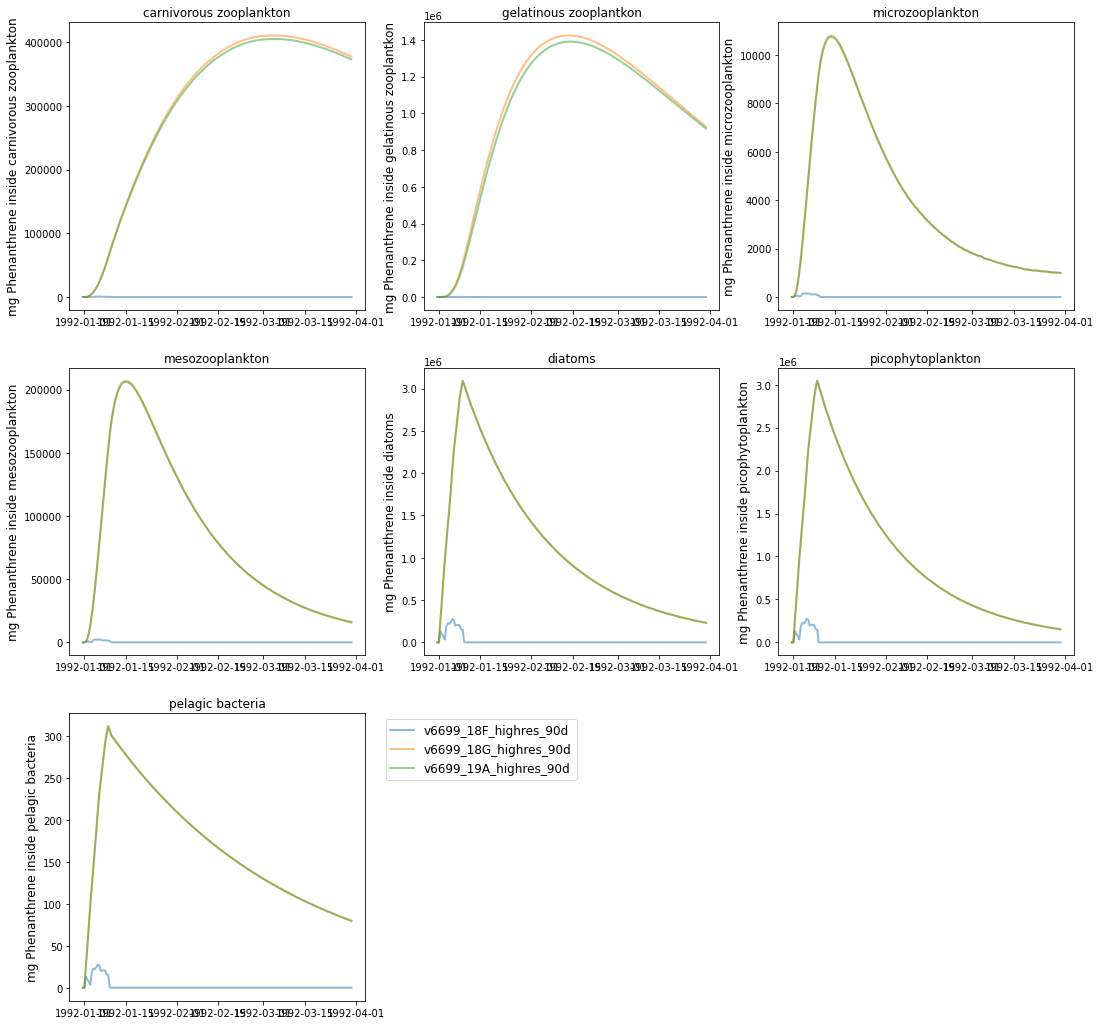

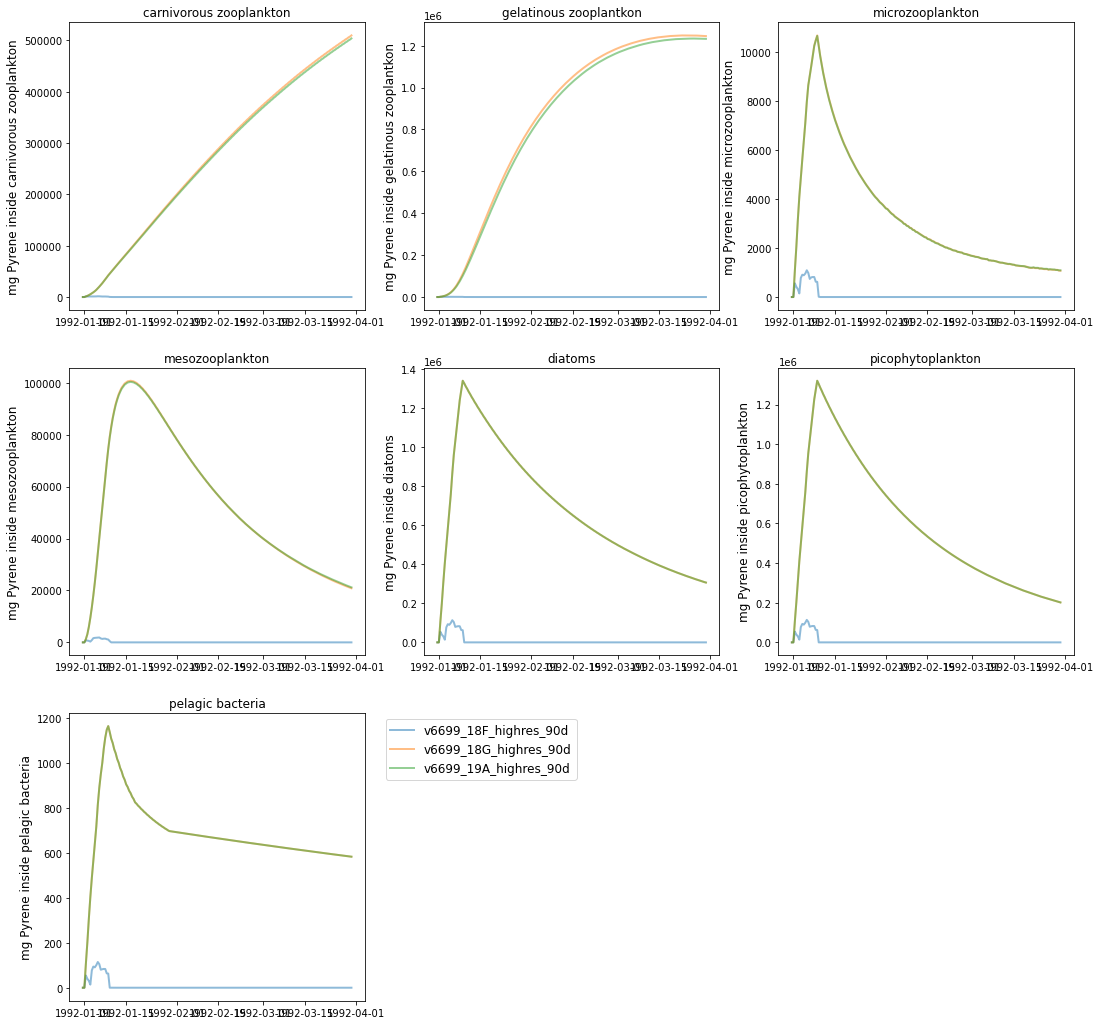

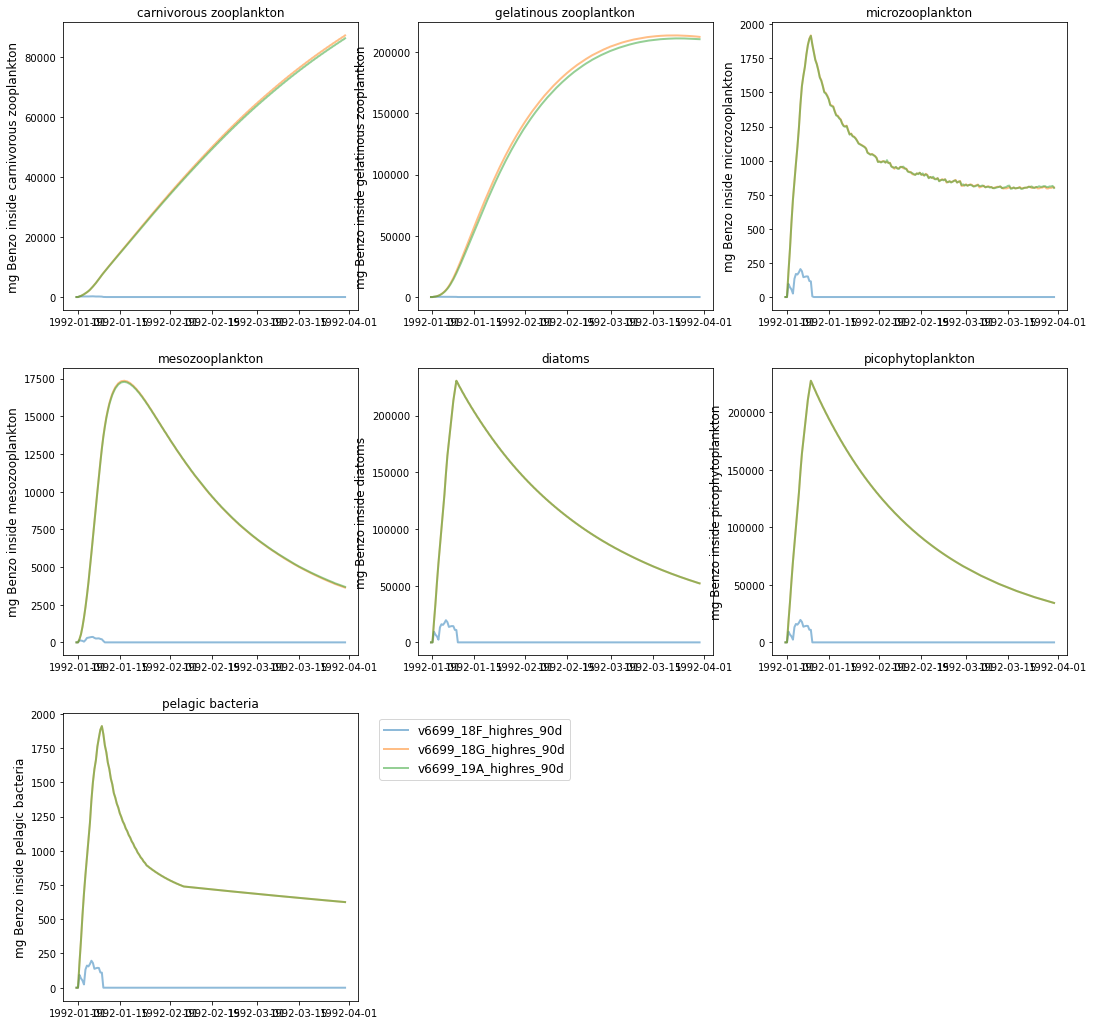

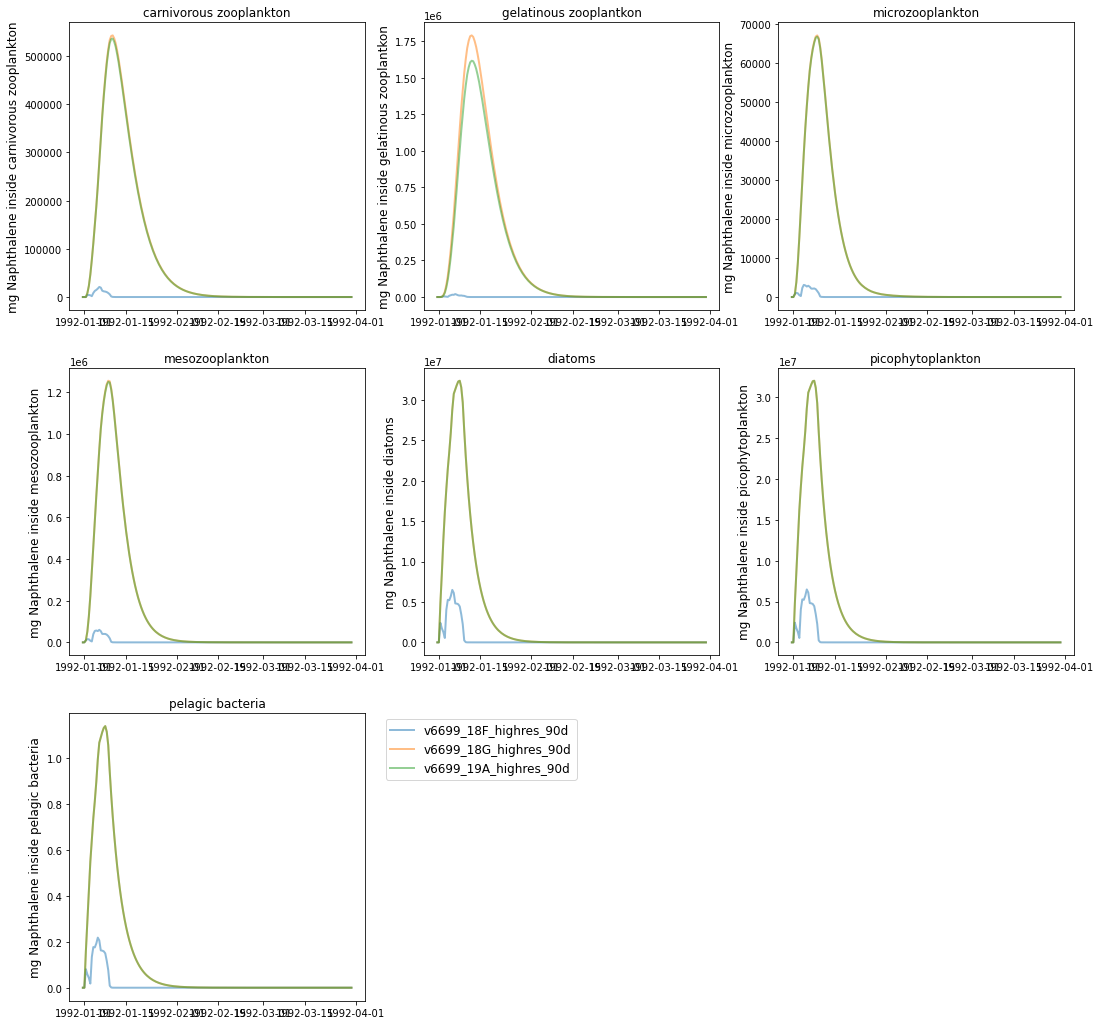

In [29]:
for pah in groups.pahs:
    tissue_mass(groups.plankton, pah, scens, testlabels)

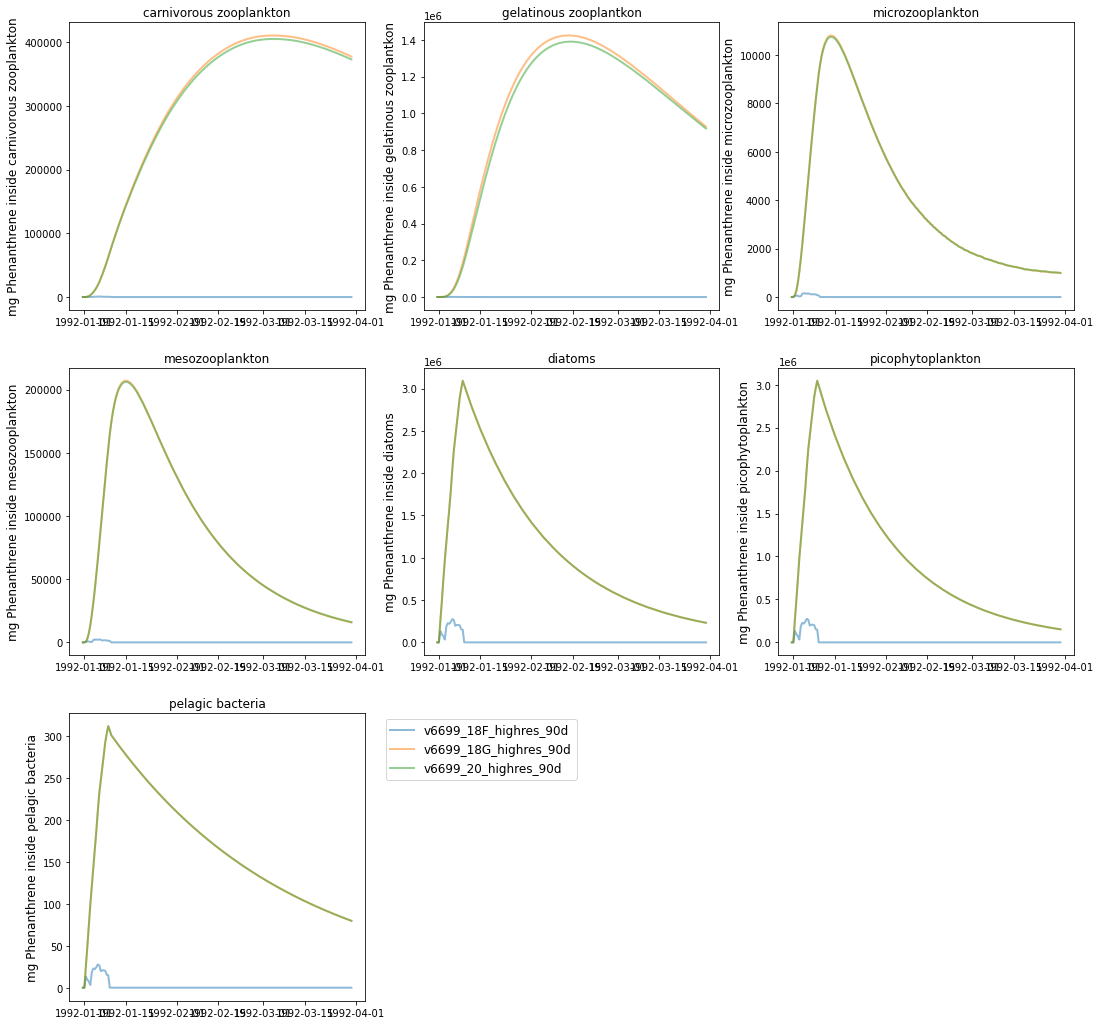

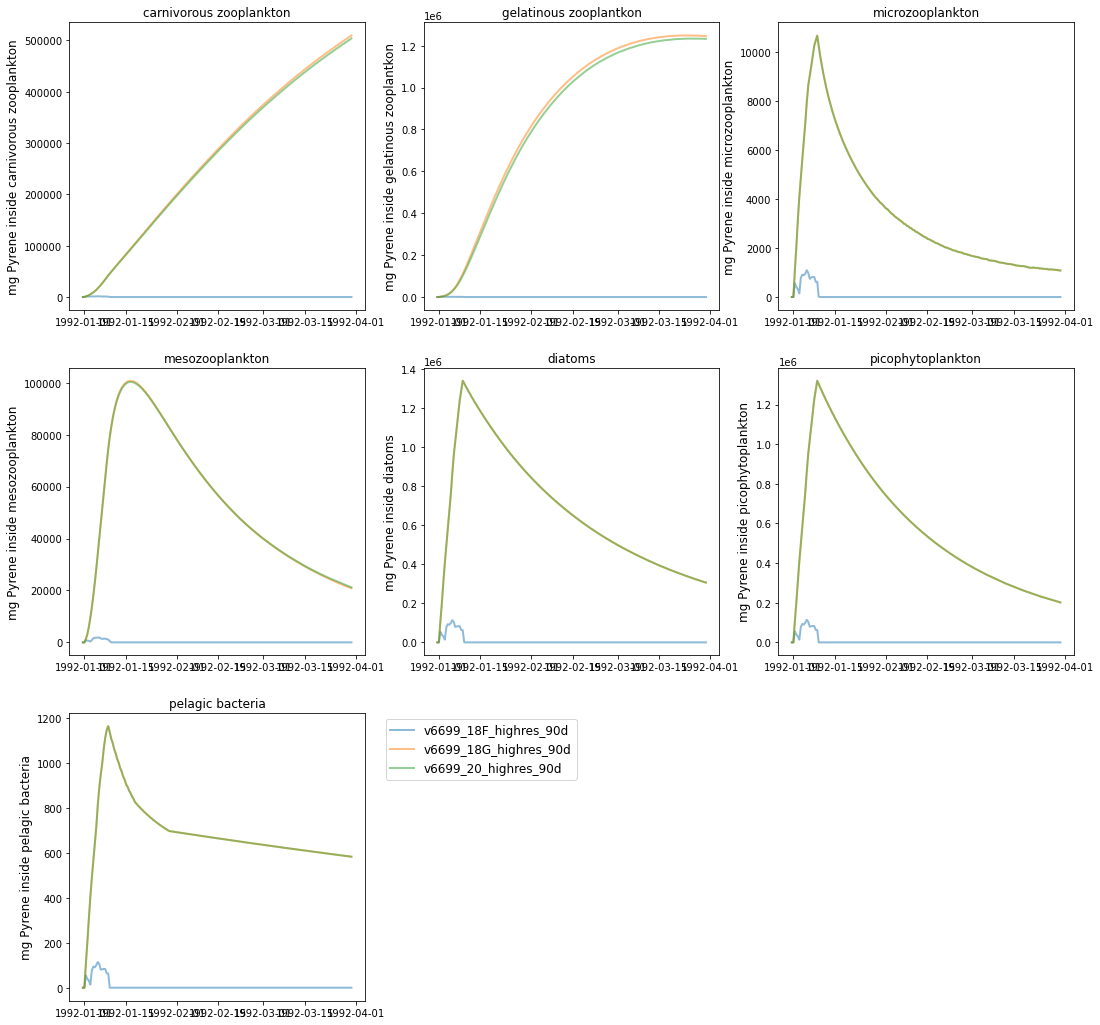

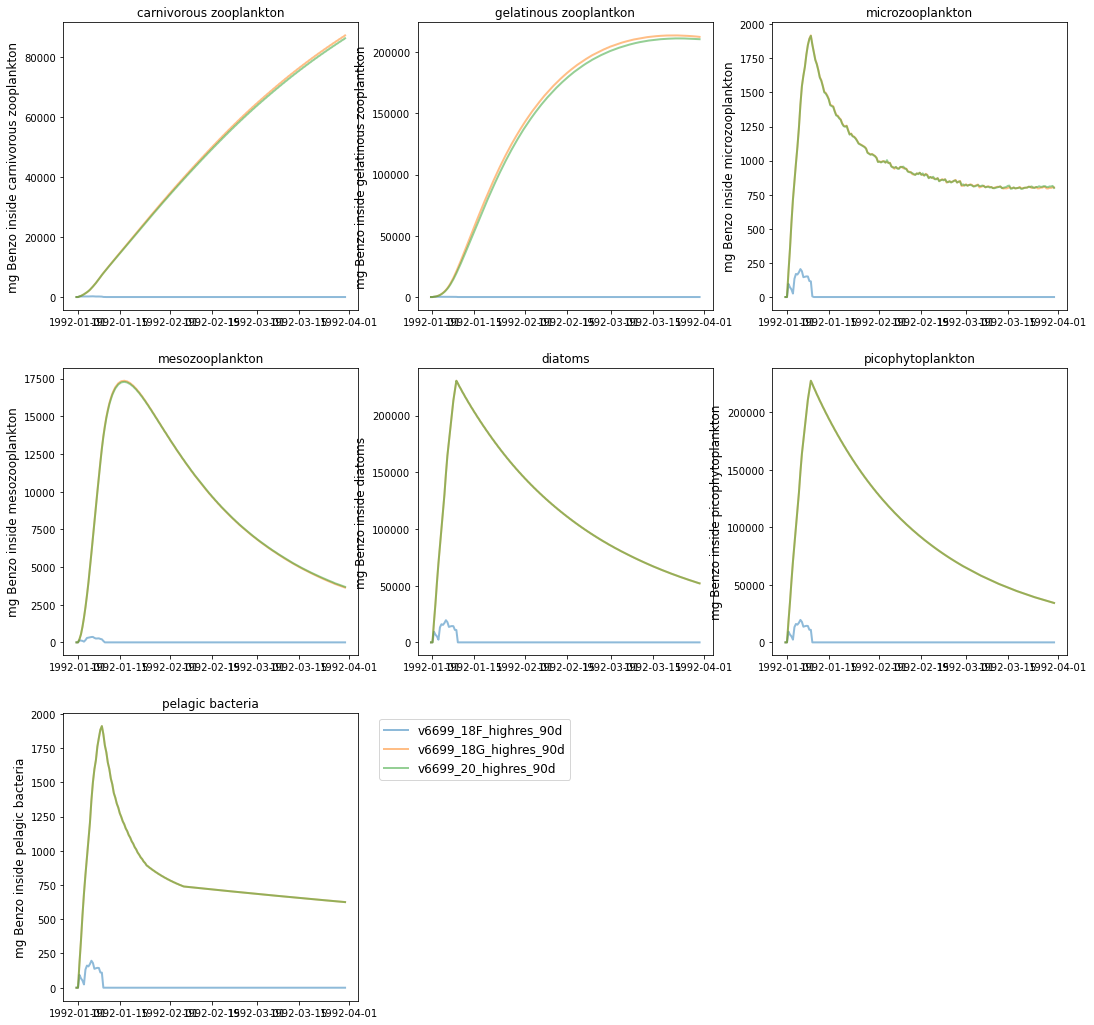

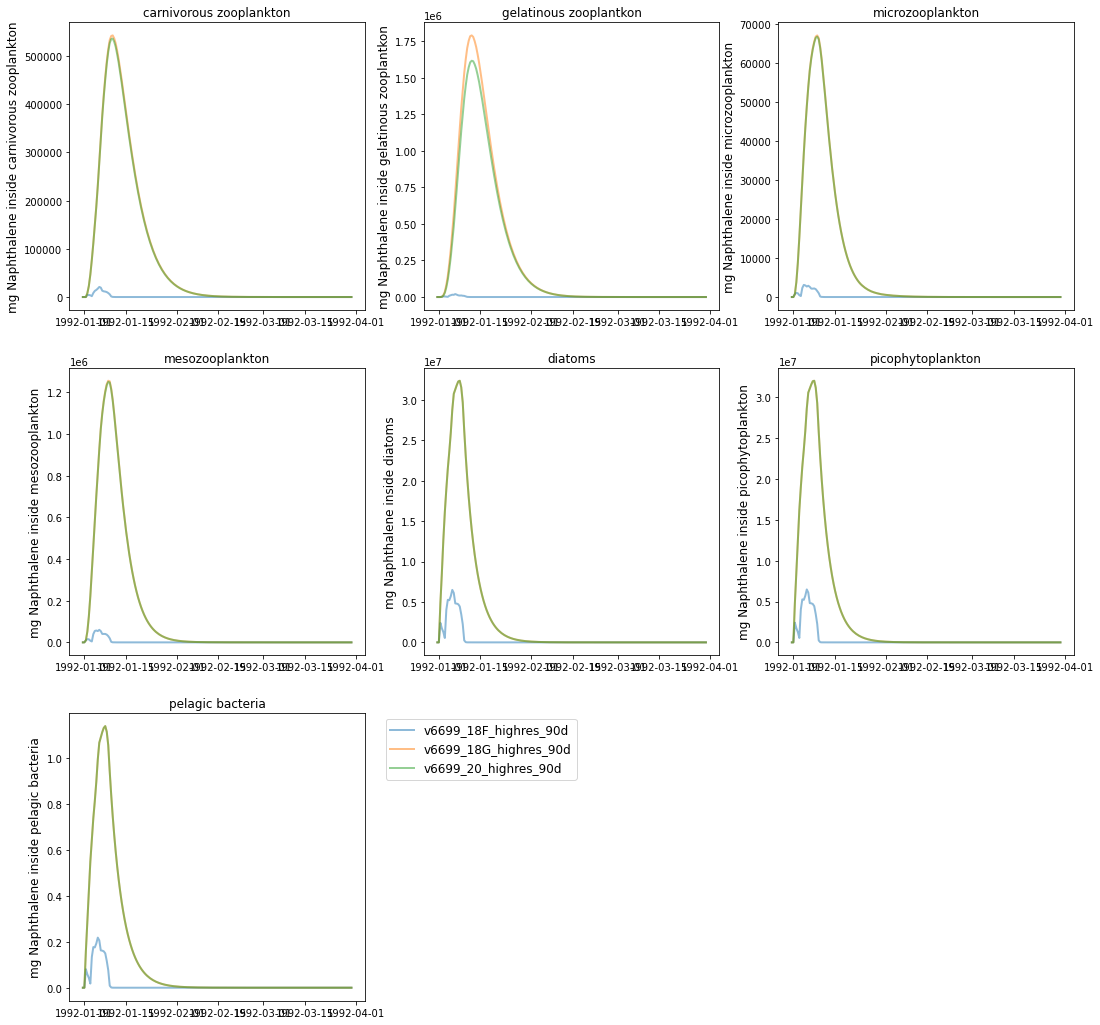

In [36]:
for pah in groups.pahs:
    tissue_mass(groups.plankton, pah, scens, testlabels)